# Pure Python Lazy Modified Goldstein Adaptive Filter

Used processed grids from S1A_Stack_CPGF_T173.tar.gz

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
# supress numpy warnings
import warnings
warnings.filterwarnings('ignore')
from dask.distributed import Client

In [2]:
# plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
# Open output data files
out_phase = xr.open_dataarray('phasefilt_phase.nc')
out_corr  = xr.open_dataarray('phasefilt_corr.nc')
out_phase.shape, out_corr.shape

((5484, 5393), (5484, 5393))

In [4]:
# Open source data files
imag = xr.open_dataarray('imagfilt.nc')
real = xr.open_dataarray('realfilt.nc')
amp1 = xr.open_dataarray('amp1.nc')
amp2 = xr.open_dataarray('amp2.nc')
imag.shape, real.shape, amp1.shape, amp2.shape

((5484, 5393), (5484, 5393), (5484, 5393), (5484, 5393))

In [5]:
def apply_pspec(data, alpha):
    if alpha < 0:
        raise ValueError("alpha < 0; something is rotten in Denmark")

    wgt = np.power(np.abs(data)**2, alpha / 2)
    data = wgt * data

    return data

# # Example usage
# alpha = 0.8
# in_array = np.array([
#     [1+1j, 2+2j, 3+3j, 4+4j],
#     [1-1j, 2-2j, 3-3j, 4-4j],
#     [1+1j, 2+2j, 3+3j, 4+4j],
#     [1-1j, 2-2j, 3-3j, 4-4j]
# ], np.complex64)

# py_out = apply_pspec(in_array, alpha)
# print(py_out)

In [6]:
def make_wgt(nxp, nyp):
    # Create arrays of horizontal and vertical weights
    wx = 1.0 - np.abs(np.arange(nxp // 2) - (nxp / 2.0 - 1.0)) / (nxp / 2.0 - 1.0)
    wy = 1.0 - np.abs(np.arange(nyp // 2) - (nyp / 2.0 - 1.0)) / (nyp / 2.0 - 1.0)
    
    # Compute the outer product of wx and wy to create the top-left quadrant of the weight matrix
    quadrant = np.outer(wy, wx)
    
    # Create a full weight matrix by mirroring the quadrant along both axes
    wgt = np.block([[quadrant, np.flip(quadrant, axis=1)],
                    [np.flip(quadrant, axis=0), np.flip(np.flip(quadrant, axis=0), axis=1)]])

    return wgt


#make_wgt(6,4)
# array([[0. , 0. , 0. , 0. , 0. , 0. ],
#        [0. , 0.5, 1. , 1. , 0.5, 0. ],
#        [0. , 0.5, 1. , 1. , 0.5, 0. ],
#        [0. , 0. , 0. , 0. , 0. , 0. ]])

In [7]:
def calc_corr(A1, A2, amp):
    a = A1 * A2
    corr = xr.where(a > 0, amp / np.sqrt(a), 0)
    corr = xr.where(corr < 0, 0, corr)
    corr = xr.where(corr > 1, 1, corr)
    return corr

#amp = np.sqrt(real**2 + imag**2)
#corr = calc_corr(amp1, amp2, amp)
#corr[::10,::10].plot()

In [8]:
psize = 32

amp = np.sqrt(real**2 + imag**2)
corr = calc_corr(amp1, amp2, amp)

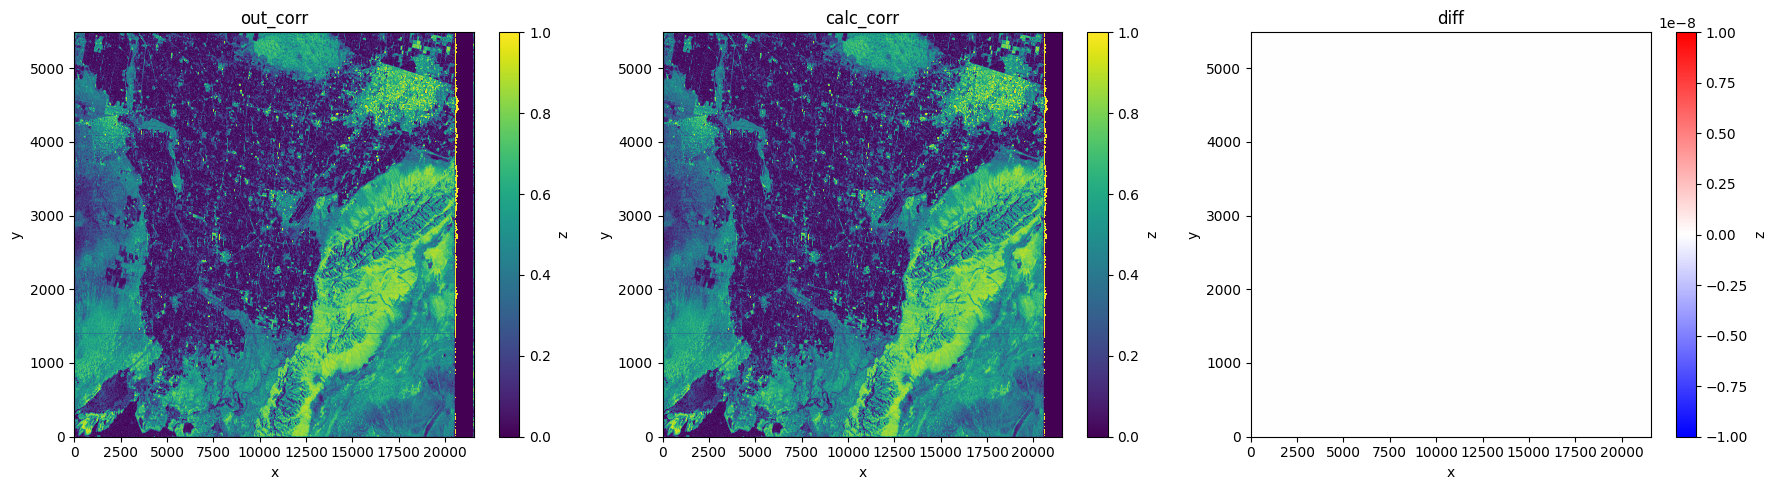

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

out_corr.plot.imshow(ax=ax0)
ax0.set_title('out_corr')

corr.plot.imshow(ax=ax1)
ax1.set_title('calc_corr')

(out_corr-corr).plot.imshow(ax=ax2, vmin=-1e-8, vmax=1e-8, cmap='bwr')
ax2.set_title('diff')

plt.tight_layout()
plt.show()

In [10]:
%%time

def goldstein_filter_complex(data, corr, wgt):
    """
    Apply the Goldstein adaptive filter to the given data.
    
    Args:
        data: 2D numpy array of complex values representing the data to be filtered.
        corr: 2D numpy array of correlation values. Must have the same shape as `data`.
        
    Returns:
        2D numpy array of filtered data.
    """
    
    # Calculate alpha
    alpha = 1 - (wgt * corr).sum() / wgt.sum()
    
    data = np.fft.fft2(data)
    data = apply_pspec(data, alpha)
    data = np.fft.ifft2(data)
    return wgt * data

def apply_goldstein_filter_numpy(data, corr, psize):
    # Create an empty array for the output
    out = np.zeros(data.shape, dtype=np.complex64)
    
    # Create the weight matrix
    wgt_matrix = make_wgt(psize, psize)
    
    # Iterate over windows of the data
    for i in range(0, data.shape[0] - psize, psize // 2):
        for j in range(0, data.shape[1] - psize, psize // 2):
            # Create proocessing windows
            data_window = data[i:i+psize, j:j+psize]
            corr_window = corr[i:i+psize, j:j+psize]
            wgt_window = wgt_matrix[:data_window.shape[0],:data_window.shape[1]]
            
            # Apply the filter to the window
            filtered_window = goldstein_filter_complex(data_window, corr_window, wgt_window)
            
            # Add the result to the output array
            slice_i = slice(i, min(i + psize, out.shape[0]))
            slice_j = slice(j, min(j + psize, out.shape[1]))
            out[slice_i, slice_j] += filtered_window[:slice_i.stop - slice_i.start, :slice_j.stop - slice_j.start]

    # Return the output array
    return out


# prepare processing dataarray
complex_data = (real + 1j * imag)

# Convert xarrays to numpy arrays
complex_data_np = complex_data.values
corr_np = corr.values

# Apply the function
filtered_data_np = apply_goldstein_filter_numpy(complex_data_np, corr_np, psize)

# Calculate the phase
filtphase_np = np.arctan2(filtered_data_np.imag, filtered_data_np.real)

CPU times: user 6.84 s, sys: 126 ms, total: 6.97 s
Wall time: 7.05 s


In [11]:
filtphase_np.shape, corr.shape

((5484, 5393), (5484, 5393))

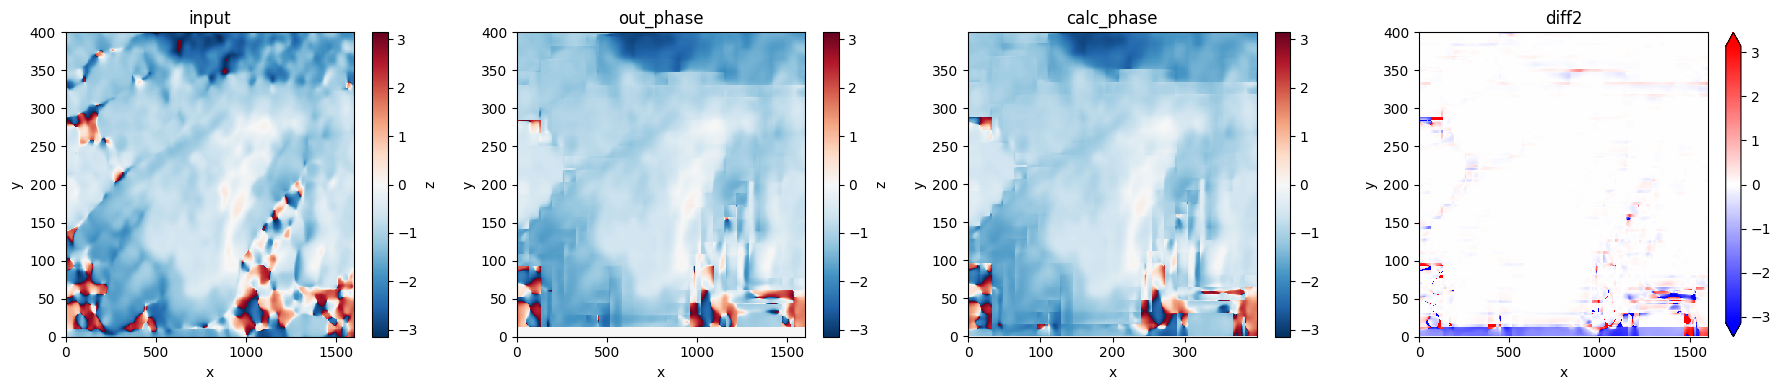

In [12]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

np.arctan2(imag, real)[:400,:400].plot.imshow(ax=ax0)
ax0.set_title('input')

out_phase[:400,:400].plot.imshow(ax=ax1)
ax1.set_title('out_phase')

xr.DataArray(filtphase_np, dims=corr.dims)[:400,:400].plot.imshow(ax=ax2)
ax2.set_title('calc_phase')

(xr.DataArray(filtphase_np, dims=corr.dims) - out_phase)[:400,:400].plot.imshow(vmin=-np.pi, vmax=np.pi, cmap='bwr', ax=ax3)
ax3.set_title('diff2')

plt.tight_layout()
plt.show()

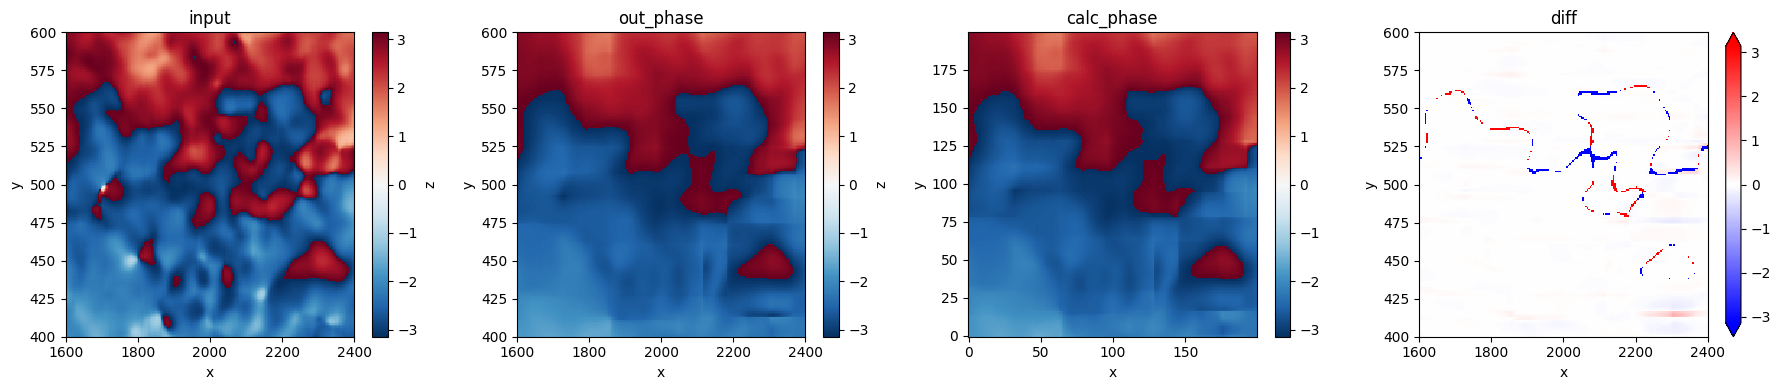

In [13]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

np.arctan2(imag, real)[400:600,400:600].plot.imshow(ax=ax0)
ax0.set_title('input')

out_phase[400:600,400:600].plot.imshow(ax=ax1)
ax1.set_title('out_phase')

xr.DataArray(filtphase_np, dims=corr.dims)[400:600,400:600].plot.imshow(ax=ax2)
ax2.set_title('calc_phase')

(xr.DataArray(filtphase_np, dims=corr.dims) - out_phase)[400:600,400:600].plot.imshow(vmin=-np.pi, vmax=np.pi, cmap='bwr', ax=ax3)
ax3.set_title('diff')

plt.tight_layout()
plt.show()

In [17]:
%%time

import dask


def goldstein_filter(data, corr, wgt, psize):
    """
    Apply the Goldstein adaptive filter to the given data.
    
    Args:
        data: 2D numpy array of complex values representing the data to be filtered.
        corr: 2D numpy array of correlation values. Must have the same shape as `data`.
        
    Returns:
        2D numpy array of filtered data.
    """
    # Calculate alpha
    alpha = 1 - (wgt * corr).sum() / wgt.sum()
    
    data = np.fft.fft2(data, s=(psize,psize))
    data = apply_pspec(data, alpha)
    data = np.fft.ifft2(data, s=(psize,psize))
    return wgt * data

def apply_goldstein_filter(data, corr, psize):
    
    # Create an empty array for the output
    out = np.zeros(data.shape, dtype=np.complex64)
    
    # ignore processing for empty chunks 
    if np.all(np.isnan(data)):
        return out
    
    # Create the weight matrix
    wgt_matrix = make_wgt(psize, psize)
    
    # Iterate over windows of the data
    for i in range(0, data.shape[0] - psize, psize // 2):
        for j in range(0, data.shape[1] - psize, psize // 2):
            # Create proocessing windows
            data_window = data[i:i+psize, j:j+psize]
            corr_window = corr[i:i+psize, j:j+psize]
            wgt_window = wgt_matrix[:data_window.shape[0],:data_window.shape[1]]
            
            # Apply the filter to the window
            filtered_window = goldstein_filter(data_window, corr_window, wgt_window, psize)
            
            # Add the result to the output array
            slice_i = slice(i, min(i + psize, out.shape[0]))
            slice_j = slice(j, min(j + psize, out.shape[1]))
            out[slice_i, slice_j] += filtered_window[:slice_i.stop - slice_i.start, :slice_j.stop - slice_j.start]

    return out

# Define a function to apply to each chunk
def func(data, corr):
    #print (data.shape)
    return apply_goldstein_filter(data, corr, psize)

# Apply function with overlap; psize//2 overlap is not enough (some empty lines produced) 
filtered_data = dask.array.map_overlap(func, complex_data.chunk(512).data, corr.chunk(512).data,
                       depth=psize//2 + 2, dtype=np.float32, meta=np.array(()))
# Calculate the phase
filtphase = np.arctan2(filtered_data.imag, filtered_data.real).compute()

# array(0.00010673) Wall time: 8.7 s
print (np.sqrt(((xr.DataArray(filtphase, dims=corr.dims) - out_phase)**2).sum())/corr.size)

filtphase

<xarray.DataArray ()>
array(0.00011035)
CPU times: user 10.3 s, sys: 7.73 s, total: 18 s
Wall time: 9.93 s


array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -1.1862125, -1.1683398, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -1.1895381, -1.1711667, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

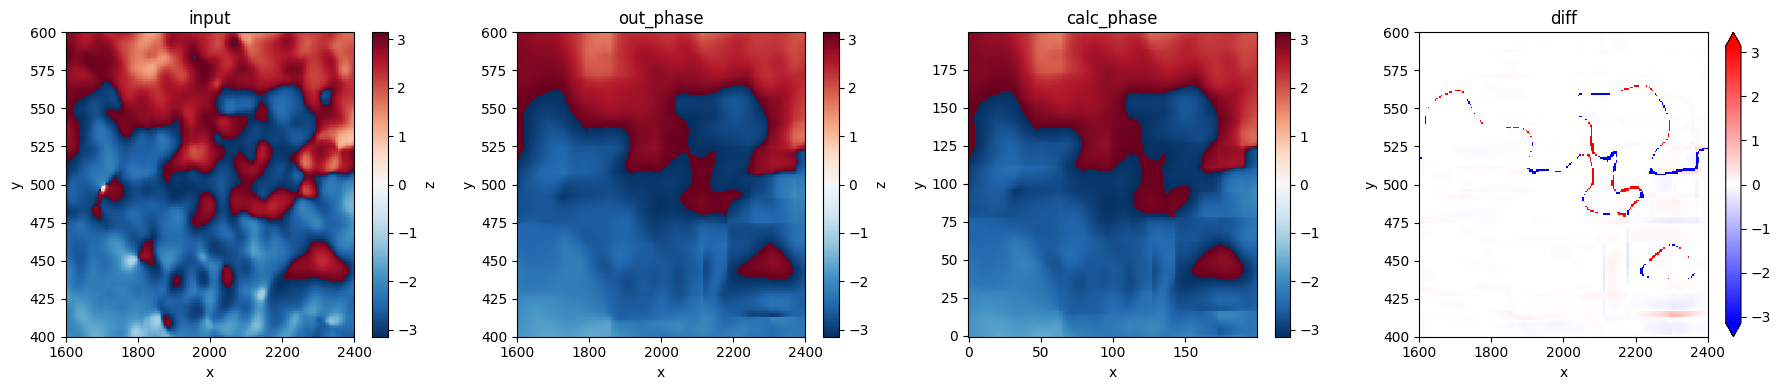

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

np.arctan2(imag, real)[400:600,400:600].plot.imshow(ax=ax0)
ax0.set_title('input')

out_phase[400:600,400:600].plot.imshow(ax=ax1)
ax1.set_title('out_phase')

xr.DataArray(filtphase, dims=corr.dims)[400:600,400:600].plot.imshow(ax=ax2)
ax2.set_title('calc_phase')

(xr.DataArray(filtphase, dims=corr.dims) - out_phase)[400:600,400:600].plot.imshow(vmin=-np.pi, vmax=np.pi, cmap='bwr', ax=ax3)
ax3.set_title('diff')

plt.tight_layout()
plt.show()

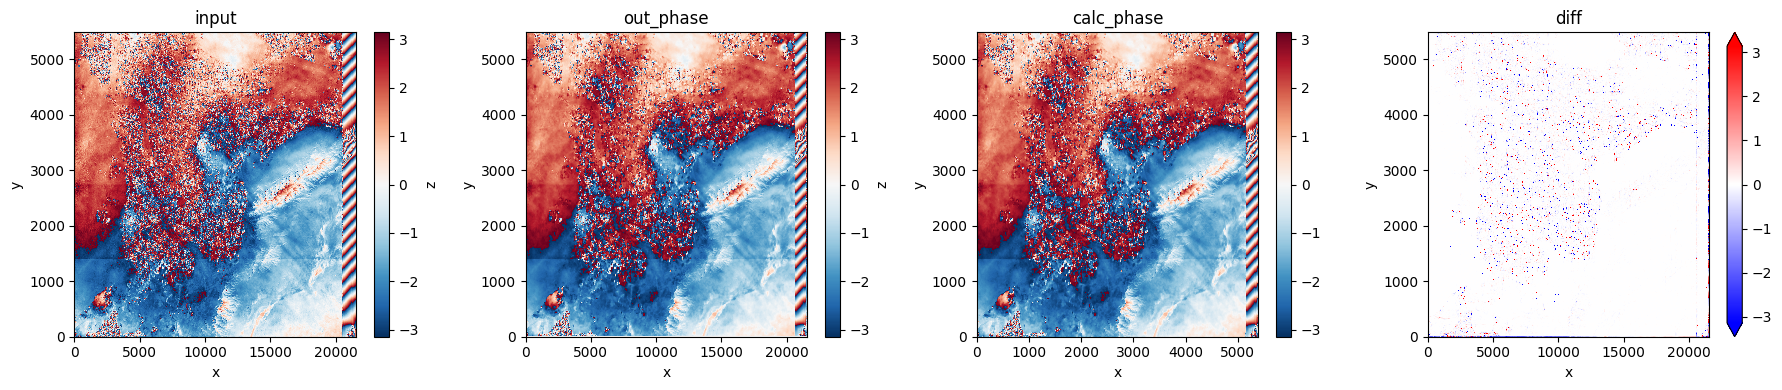

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

np.arctan2(imag, real).plot.imshow(ax=ax0)
ax0.set_title('input')

out_phase.plot.imshow(ax=ax1)
ax1.set_title('out_phase')

xr.DataArray(filtphase, dims=corr.dims).plot.imshow(ax=ax2)
ax2.set_title('calc_phase')

(xr.DataArray(filtphase, dims=corr.dims) - out_phase).plot.imshow(vmin=-np.pi, vmax=np.pi, cmap='bwr', ax=ax3)
ax3.set_title('diff')

plt.tight_layout()
plt.show()